###### Bulgaria Employment Trends 
[Go back to the main page](./../Bulgaria_Employment_Trends.ipynb)

---------

## Salary Transparency

----------
### Introduction

The main objective of this visualization is to illustrate the ratio of job offer ads that have a salary announced as a part of the total offer count. This can help answer questions such as "Is there a trend for the companies to be more public about the salary they offer?", and "Are there seasonal changes in the salary transparency ratio?".

A percent stacked area graph was chosen to illustrate the salary transparency ratio. In this type of chart the value of each group is normalized at each time stamp and presented as a percentage part of the whole, allowing the reader to compare the groups that compose the whole. In order to hide the noise from daily fluctuations the data has been aggregated in week time period bins.


### Methodology

1. Data Fetch & Prototyping.
 - Obtain the data from the predefined view stored in the database.
 - Create a prototype chart in `matplotlib` to quickly illustrate the chart and see any discrepances.
2. Implement the chart in `Plot.ly`. 

### Data Fetch & Prototyping

Using `matplotlib` to rapidly create an example graph.

In [1]:
import psycopg2
import pandas as pd
import matplotlib

from nbstyler import STYLE

%matplotlib notebook
%matplotlib inline

First we need to fetch the data from the database. A predefined query will return the counts we need, but we need to drop the first and last week from the result since they contain partial data for the relevant periods. Finally, visually inspect a couple of lines to confirm that the data looks as expected.

In [2]:
conn = psycopg2.connect("dbname=jobsbg")
query = 'SELECT * FROM v_count_weekly_published_vs_unpublished_salary'

data_df = pd.read_sql_query(query, conn, index_col='week_ts')
data_df = data_df[1:-1]  # first and last week are incomplete so we drop them.
data_df.index = pd.to_datetime(data_df.index)  # convert the DataFrame index to DatetimeIndex object
data_df.head(2)

,published_salary,unpublished_salary
week_ts,,
2017-10-02,2076,7191
2017-10-09,2058,6883


To create the `matplotlib` chart we need the counts converted to percentages that represent a part of the whole for each individual week. When stacked together the parts will add up to 100%. The values needed are created and attached as additional columns to the Pandas DataFrame.

In [3]:
publ_salary_ratio = data_df.apply(lambda row: row.published_salary / (row.published_salary + row.unpublished_salary) * 100, axis=1)
unpubl_salary_ratio = data_df.apply(lambda row: row.unpublished_salary / (row.published_salary + row.unpublished_salary) * 100, axis=1)

data_df = data_df.assign(publ_salary_ratio=publ_salary_ratio.values)
data_df = data_df.assign(unpubl_salary_ratio=unpubl_salary_ratio.values)
data_df.head(1)

,published_salary,unpublished_salary,publ_salary_ratio,unpubl_salary_ratio
week_ts,,,,
2017-10-02,2076,7191,22.402072,77.597928


A prototype chart view using the Pandas' `DataFrame.plot()` method can quickly show if the data is ready for plotting.

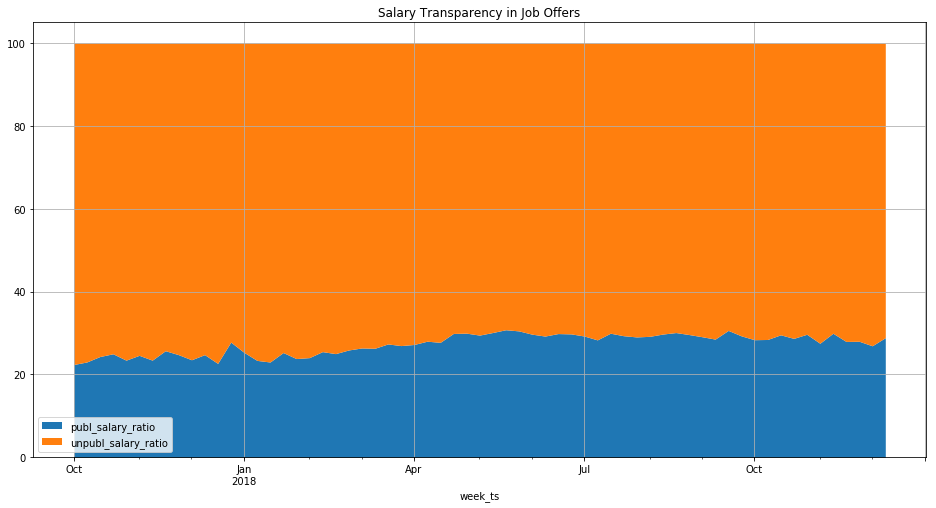

In [4]:
cols_to_plot = ['publ_salary_ratio', 'unpubl_salary_ratio']
data_df.plot(
    title='Salary Transparency in Job Offers',
    y=cols_to_plot,
    kind='area',
    grid=True,
    linewidth=0,
    figsize=(16,8)
)

This seems to be a good place to move on to Plotly.

### Implementing the Chart in Plotly





In [5]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline

Constructing the area traces for both possible values. They represent the data for the Plotly plot. Drawing directly as a line shape.

In [6]:
trace_publ = go.Scatter(
    x = data_df.index,
    y = data_df.publ_salary_ratio,
    text = data_df.published_salary,
    hoverinfo = 'text', 
    mode = 'lines',
    line = dict(
        width = 2, 
        color = STYLE['colors']['solid']['acc1'],
        shape = 'spline',
    ),
    fillcolor = STYLE['colors']['opaque']['acc1'],
    stackgroup = 'one',
    name = 'Published Salary',
)

trace_unpubl = go.Scatter(
    x = data_df.index,
    y = data_df.unpubl_salary_ratio,
    text = data_df.unpublished_salary,
    hoverinfo = 'text', 
    mode = 'lines',
    line = dict(
        width = 0, 
        color = STYLE['colors']['solid']['acc2'],
    ),
    fillcolor = STYLE['colors']['opaque']['acc2'],
    stackgroup = 'one',
    name = 'Unpublished Salary'
)

data = [trace_publ, trace_unpubl]

Preparing the layout for the Plotly plot. 

In [9]:
layout = go.Layout(
    title = 'Salary Transparency in Job Offer Ads',
    width = 920,
    height = 600,
    legend = dict(orientation = 'h'),
    modebar = dict(orientation = 'h'),
    showlegend = True,
    paper_bgcolor = STYLE['colors']['solid']['bg1'],
    plot_bgcolor = STYLE['colors']['solid']['bg1'],
    dragmode = 'zoom',
    hovermode = 'closest',
    hoverlabel = dict(bgcolor=STYLE['colors']['solid']['bg1']),
    xaxis = dict(type='date', title = '', ticks = 'outside', tickmode = 'array', tickvals = data_df.index, ticktext = data_df.index, tickangle = 0, tickformat = 'w%W/%y', nticks=20), 
    yaxis = dict(type='linear',range=[0,100], dtick=20, ticksuffix='%', fixedrange = True),
)

In [12]:
fig = go.Figure(data = data, layout = layout)
plotly.offline.iplot(fig, filename = 'salary_transparency')
# Uncomment the line below to export an HTML version of the chart.
# plotly.offline.plot(fig, filename = 'salary_transparency_result.html')